# Main



Now some text explaining stuff

## General requirements

In [1]:
from matplotlib.pylab import *
from numpy import *
%matplotlib inline

In [2]:
from Nanorods.sub.subs import *

In [3]:
#from Nanorods.sub.subs import *\    
def visualization(imA,pos=None,widthr=5,heightr=5,contrastd=1.0,contrastu=2.5,figname="",color='red',figsize = (7,4.5)):
    fig = figure(figname,figsize = figsize)
    ax = fig.add_subplot(111)
    imt = imA*1.0; me = mean(imt.flatten()); sd = std(imt.flatten());
    imt[imt>me+contrastu*sd] = me+contrastu*sd; imt[imt<me-contrastd*sd] = me-contrastd*sd;
    ax.imshow(imt,cmap='gray')
    if pos is None:
        pass
    else:
        for a_x, a_y in pos:
            ax.add_patch(Rectangle(xy=(a_x-widthr/2, a_y-heightr/2) ,width=widthr, height=heightr, linewidth=1.5, color=color,alpha=0.95, fill=False))
    axis('off')
    subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    margins(0,0)
    gca().xaxis.set_major_locator(NullLocator())
    gca().yaxis.set_major_locator(NullLocator())

    return((fig,ax))


In [4]:
import PIL
import PIL.ExifTags as Exiftags

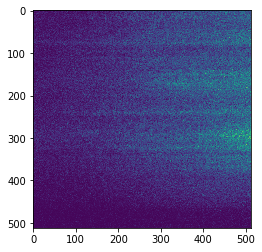

In [5]:
fname = "C:\\Users\ludwig\Documents\Python data\cell1_BeRST.tif"
img = PIL.Image.open(fname)
imshow(img)

In [6]:
img = PIL.Image.open(fname)
#imshow(img)
imf = img.tag_v2
keys = []
for i,key in enumerate(imf.keys()):
    if i < 8:
        print(key,imf[key])
    keys.append(key)
offset = 50839


256 512
257 512
258 (16,)
262 1
270 ImageJ=1.52h
images=200
frames=200
unit=micron
finterval=0.09999948740005493
loop=false
min=110.0
max=49469.0

273 (72711,)
277 1
278 512


In [6]:
int(imf[270].split()[1][7:])

200

In [7]:
def readBigTifFile(fname):
    img = PIL.Image.open(fname)
    imf = img.tag_v2
    keys = []
    for key in imf.keys():
        keys.append(key)

    width, height = imf[keys[0]],imf[keys[1]]
    nframes = int(imf[270].split()[1][7:])
    size = nframes*width*height
    
    offset = imf[273][0]
    print(offset)
    with open(fname,"rb") as file:
        file.seek(offset)
        temp = fromfile(file,dtype=">u2")

    temp = temp[:size].reshape((nframes,height,width))
    return(temp)

In [8]:
fname = "C:\\Users\ludwig\Documents\Python data\cell1_BeRST.tif"
movie = readBigTifFile(fname)
movie = movie.sum(axis=0)

72711


(<Figure size 504x324 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x25fc4937898>)

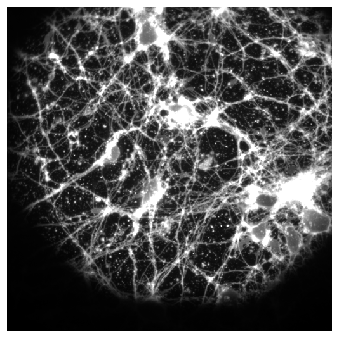

In [9]:
visualization(movie)

In [10]:
fname = "C:\\Users\ludwig\Documents\Python data\cell1_1.tif"
movie = readBigTifFile(fname)
movie = movie.sum(axis=0) # sum(movie,axis=0)

6517240


(<Figure size 504x324 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x25fc46db4e0>)

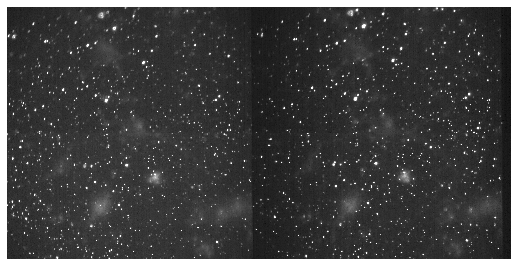

In [11]:
visualization(movie)

##     Mask generation and three fields alignment.

### cMOS camera fields alignment
### EMCCD mask generation
### Transposition of mask two CMOS images


In [42]:
import os
#import warning
import numpy as np
from scipy.stats import  linregress

def EMCCD_CMOS_calib(folder = './',csv = True, ROIsize=9):

    #Extracting images and csv files
    files_tif = []
    files_csv = []
    # ~ filenames = []
    for file in os.listdir(folder):
        if file.endswith('.tif'):
            files_tif.append(file)
            # ~ filenames.append(file.split('_')[0])
        elif file.endswith('.csv'):
            files_csv.append(file)
            
    
    # ~ filenames = list(set(filenames))
    # ~ filenames.sort()
    files_tif.sort()
    files_csv.sort()
    #files = {name: [] for name in filenames}
        
    # Let us subdivide files with name of the cell
    # ~ for file in files_tif:
        # ~ filename = file.split('_')[0]
        # ~ files[filename].append(file)
    
    files = files_tif
    filesCMOS = [file for file in files if file.find('CMOS')>=0]
    if len(filesCMOS) == 0:
        raise 'Sorry, there are no files with CMOS in their name.'
    
    
    filesEMCCD = [file for file in files if file.find('EMCCD')>=0]
    if len(filesEMCCD)==0:
        raise 'We stop, no files with EMCCD in their name, for '+name+'.'
        
    
    ptsC = []
    ptsE = []
    for i,names in enumerate(zip(filesCMOS,filesEMCCD)): #real traces
        fCMOS, fEMCCD = names
    
        # Change these lines to appropiate reading of tif files:
        CMOS = imread(folder+fCMOS)
        EMCCD= imread(folder+fEMCCD)
    
        CMOS = CMOS[:,:CMOS.shape[1]//2]
    
        if not csv:
            # Produce csv - pass it to subroutine    
            pass
        else:
            fCMOScsv, fEMCCDcsv =  (filesCMOScsv[i],filesEMCCDcsv[i])
            # ReadROIS!? Show me csv files
            CMOS_pts = ReadROIs(loadtxt(fCMOS))
            EMCCD_pts  = ReadROIs(loadtxt(fEMCCD))
        
        #CenterROIs function
        CMOS_pts_center=CenterROIs(CMOS,CMOS_pts,ROIsize);
        EMCCD_pts_center=CenterROIs(EMCCD,EMCCD_pts,ROIsize);
        ptsC.append(CMOS_pts_center)
        ptsE.append(EMCCD_pts_center)

    ptsC = np.array(ptsC)
    ptsE = np.array(ptsE)
    Xc=ptsC[:,0]
    Yc=ptsC[:,1]
    Xe=ptsE[:,0]
    Ye=ptsE[:,1]

    fitobject = linregress(Xc,Xe)
    #slope, intercept, r_value, p_value, std_err
    ax, bx, _, _, _ = fitobject

    fitobject = linregress(Yc,Ye)
    #slope, intercept, r_value, p_value, std_err
    ax, bx, _, _, _ = fitobject

    return(ax,ay,bx,by)

In [23]:
import os
#import warning
import numpy as np
from scipy.stats import  linregress

folder='C:\\Users\\ludwig\\data\\NR sample files\\18_11_29_pd23_11_div6_WIS_NR-BeRST\\image files\\EMCCD-CMOS calib\\'
os.listdir(folder)

['calib_CMOS_1.csv',
 'calib_CMOS_1.tif',
 'calib_CMOS_1.zip',
 'calib_CMOS_2.csv',
 'calib_CMOS_2.tif',
 'calib_CMOS_2.zip',
 'calib_CMOS_3.csv',
 'calib_CMOS_3.tif',
 'calib_CMOS_3.zip',
 'calib_EMCCD_1.csv',
 'calib_EMCCD_1.tif',
 'calib_EMCCD_1.zip',
 'calib_EMCCD_2.csv',
 'calib_EMCCD_2.tif',
 'calib_EMCCD_2.zip',
 'calib_EMCCD_3.csv',
 'calib_EMCCD_3.tif']

In [28]:
#[ax, ay, bx, by]=EMCCD_CMOS_calib(folder+"\EMCCD_CMOS_calib");
csv = True
ROIsize=9
#Extracting images and csv files
files_tif = []
files_csv = []
# ~ filenames = []
for file in os.listdir(folder):
    if file.endswith('.tif'):
        files_tif.append(file)
        # ~ filenames.append(file.split('_')[0])
    elif file.endswith('.csv'):
        files_csv.append(file)


# ~ filenames = list(set(filenames))
# ~ filenames.sort()
files_tif.sort()
files_csv.sort()
#files = {name: [] for name in filenames}

# Let us subdivide files with name of the cell
# ~ for file in files_tif:
    # ~ filename = file.split('_')[0]
    # ~ files[filename].append(file)

files = files_tif
filesCMOS = [file for file in files if file.find('CMOS')>=0]
#if len(filesCMOS) == 0:
#    raise 'Sorry, there are no files with CMOS in their name.'


filesEMCCD = [file for file in files if file.find('EMCCD')>=0]
#if len(filesEMCCD)==0:
#    raise 'We stop, no files with EMCCD in their name, for '+name+'.'
files = files_csv
filesCMOScsv = [file for file in files if file.find('CMOS')>=0]
#if len(filesCMOS) == 0:
#    raise 'Sorry, there are no files with CMOS in their name.'


filesEMCCDcsv= [file for file in files if file.find('EMCCD')>=0]

In [27]:
print(files_csv)

['calib_CMOS_1.csv', 'calib_CMOS_2.csv', 'calib_CMOS_3.csv', 'calib_EMCCD_1.csv', 'calib_EMCCD_2.csv', 'calib_EMCCD_3.csv']


In [29]:
ptsC = []
ptsE = []
for i,names in enumerate(zip(filesCMOS,filesEMCCD)): #real traces
    fCMOS, fEMCCD = names

    # Change these lines to appropiate reading of tif files:
    CMOS = imread(folder+fCMOS)
    EMCCD= imread(folder+fEMCCD)

    CMOS = CMOS[:,:CMOS.shape[1]//2]

    if not csv:
        # Produce csv - pass it to subroutine    
        pass
    else:
        fCMOScsv, fEMCCDcsv =  (filesCMOScsv[i],filesEMCCDcsv[i])
        # ReadROIS!? Show me csv files
        CMOS_pts = ReadROIs(loadtxt(fCMOS))
        EMCCD_pts  = ReadROIs(loadtxt(fEMCCD))

    #CenterROIs function
    CMOS_pts_center=CenterROIs(CMOS,CMOS_pts,ROIsize);
    EMCCD_pts_center=CenterROIs(EMCCD,EMCCD_pts,ROIsize);
    ptsC.append(CMOS_pts_center)
    ptsE.append(EMCCD_pts_center)

ptsC = np.array(ptsC)
ptsE = np.array(ptsE)
Xc=ptsC[:,0]
Yc=ptsC[:,1]
Xe=ptsE[:,0]
Ye=ptsE[:,1]

fitobject = linregress(Xc,Xe)
#slope, intercept, r_value, p_value, std_err
ax, bx, _, _, _ = fitobject

fitobject = linregress(Yc,Ye)
#slope, intercept, r_value, p_value, std_err
ax, bx, _, _, _ = fitobject

NameError: name 'ReadROIs' is not defined

In [35]:
print(fCMOScsv)
print(folder)
loadtxt(folder+fCMOScsv)

calib_CMOS_1.csv
C:\Users\ludwig\data\NR sample files\18_11_29_pd23_11_div6_WIS_NR-BeRST\image files\EMCCD-CMOS calib\


ValueError: could not convert string to float: ',X,Y'

##   Local maxima detection and ROI detection
### Local maxima detection
### Blinking coefficient and selection
### Neural-net?


##   Processing ROIs:
### Linearization of ROI
### Blinking substraction
### Stitching cycles
### Mobility



##    Extracting Signal
### FT score calculation
### Interval extraction



##   Bootstrap?

